In [4]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import random
from numba import vectorize
from collections import defaultdict, Counter
from itertools import product,combinations,chain
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import rankdata,percentileofscore
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches


%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20.0, 10.0)
matplotlib.rcParams["font.size"] = 26
matplotlib.rcParams["axes.grid"] = True
matplotlib.rcParams["axes.facecolor"] = (0.97,0.97,0.97)

In [5]:
client = MongoClient()
db = client.swatford

In [2]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [6]:
desc_name_map = pd.Series({doc["uid"]:doc["name"] for doc in db.medline.descs.find()})

In [7]:
%run ../scripts/equations.py

In [8]:
n = db.genes.descs.ancestors.find().count()
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)

In [9]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]
searchable_df = gene_uid[(gene_uid.uid.isin(bc_uids)) & (gene_uid.npmi>0.0) & (gene_uid.g_freq>2)].copy()

In [10]:
g = nx.Graph()

In [11]:
edges = defaultdict(int)

In [12]:
for tup in list(combinations(bc_uids,2)):
    edges[tup] = len(set(searchable_df[searchable_df.uid==tup[0]].gene_id) 
                     & set(searchable_df[searchable_df.uid==tup[1]].gene_id))

In [13]:
g.add_weighted_edges_from([(k[0],k[1],v) for k,v in edges.items()])

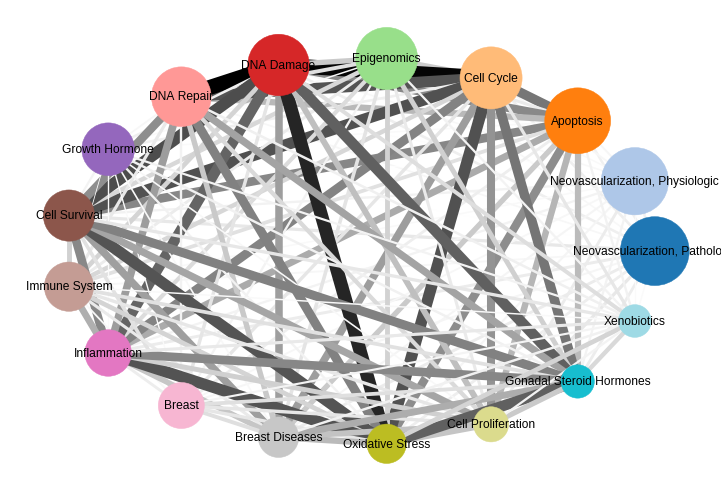

In [96]:
sns.set_context("poster")
sns.set_style("whitegrid",{"axes.grid":False,"axes.linewidth":0.0})
m = max(edges.values())

pos = nx.circular_layout(g)

ge = nx.draw_networkx_edges(g,
                            pos,
                            edgelist=g.edges(),
#                             width=[1-(x/len(df)*35) for x in edges.values()],
                            width=[(g.get_edge_data(x[0],x[1])["weight"]/max(edges.values())*15) for x in g.edges()],
                            edge_color = [(g.get_edge_data(y[0],y[1])["weight"]) for y in g.edges()],
                            edge_cmap=plt.cm.Greys
                           )
node_size=pd.Series([10000 * 
        len(searchable_df[searchable_df.uid==x].gene_id.unique())/len(searchable_df.gene_id.unique()) 
                                       for x in list(g.nodes_iter())],
                    index=g.nodes()).sort_values(ascending=False)

gn = nx.draw_networkx_nodes(g,
                            pos,
                            nodelist=g.nodes(),
                            node_color=list(range(len(g.nodes()))),
                            cmap=plt.cm.tab20,
                            node_size=node_size
                           )
node_size = node_size/node_size.max()
labels = nx.draw_networkx_labels(g,pos=pos,
                                 labels={n:desc_name_map[n] for n in g.nodes()})
gn.axes.xaxis.set_ticklabels([])
gn.axes.yaxis.set_ticklabels([])
# ncolors = gn.get_facecolors()


for n in node_size.index.values:
#     plt.plot([],"ro",color=ncolors[g.nodes().index(n)], markersize=node_size[n]/70,label=desc_name_map[n])
    plt.plot([],"ro",color=ncolors[g.nodes().index(n)], markersize=15,label=desc_name_map[n])

# l = plt.legend(bbox_to_anchor=(1.,0.2, 1., .102), loc=4,
#            ncol=1, mode="expand", borderaxespad=0.0)
# plt.savefig("g.png",dpi=250,bbox_extra_artists=(l,),bbox_inches="tight",transparent=True)

# plt.subplots_adjust(right=1.5,bottom=0.3,top=1)
# plt.tight_layout(w_pad=1)

In [95]:
{k:[v[0]+node_size[k]/2,v[1]] for k,v in pos.items()}

{'D001940': [-0.43903650022742108, -0.79801722728023949],
 'D001941': [0.003357125850180831, -0.96182564317281904],
 'D002453': [0.92380404505941138, 0.89516329135506234],
 'D002470': [-0.57616550791210952, 0.18374951781657037],
 'D004249': [0.22633700992791711, 0.96182564317281904],
 'D004260': [-0.2269669468690847, 0.7980172272802396],
 'D007107': [-0.75902719674038543, -0.18374951781657012],
 'D007249': [-0.44335271931865827, -0.52643216287735584],
 'D009389': [1.1305261961586544, 0.0],
 'D012739': [1.1382588319837006, -0.6736956436465571],
 'D013006': [-0.73293108049606492, 0.52643216287735572],
 'D015262': [1.1056737295748298, -0.36124166618715303],
 'D017209': [1.0322240553045323, 0.67369564364655721],
 'D018384': [0.54936575689482792, -0.99573417629503458],
 'D018919': [1.04566691061813, 0.36124166618715292],
 'D049109': [0.70179017984745573, -0.89516329135506223],
 'D057890': [0.32098753209655578, 0.99573417629503447]}

In [15]:
ncolors = gn.get_facecolors()

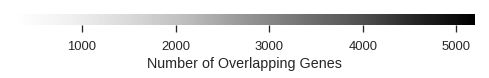

In [16]:
sns.set_context("talk")
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.8, 0.05])
norm = matplotlib.colors.Normalize(vmin=min(edges.values()),vmax=max(edges.values()))
cb1 = matplotlib.colorbar.ColorbarBase(ax1,cmap=plt.cm.Greys,norm=norm,orientation="horizontal")
cb1.set_label('Number of Overlapping Genes')
ax1.tick_params(length=7)
plt.savefig("network_colorbar.png",dpi=500,bbox_inches="tight",transparent=True)

$$overlap \space percentage = \frac{(c1 \cap c2)}{(c1 \cup c2)}$$

In [27]:
desc_name_map[bc_uids].values

array(['Neovascularization, Pathologic', 'Neovascularization, Physiologic',
       'Apoptosis', 'Cell Cycle', 'Epigenomics', 'DNA Damage',
       'DNA Repair', 'Growth Hormone', 'Cell Survival', 'Immune System',
       'Inflammation', 'Breast', 'Breast Diseases', 'Oxidative Stress',
       'Cell Proliferation', 'Gonadal Steroid Hormones', 'Xenobiotics'], dtype=object)

In [221]:
ex_edges = []
for doc in db.genes.descs.original.find({"pmid":{"$in":[7916651,10085091]}},{"_id":0,"mt":0}):
    ex_edges+=[(doc["gene_id"],doc["pmid"]),(doc["uid"],doc["pmid"])]

In [222]:
g2 = nx.Graph()

In [223]:
g2.add_edges_from(ex_edges)

In [224]:
# g2.remove_nodes_from(['D001483','D002352','D003001','D013196',
#     'D051548','D008297','D056920','D056918','D015513','D011467','D011944','D011965',
#     'D011980','D016415','D017422','D015534','D014157','D047908',
#                        'D001943',
#     'D005091',
#     'D005260',
#     'D016133',
#     'D012334',
#     'D014158',
#     9604.0,
#     367.0,
#     2908.0,
#     8031.0,
#     9246.0])

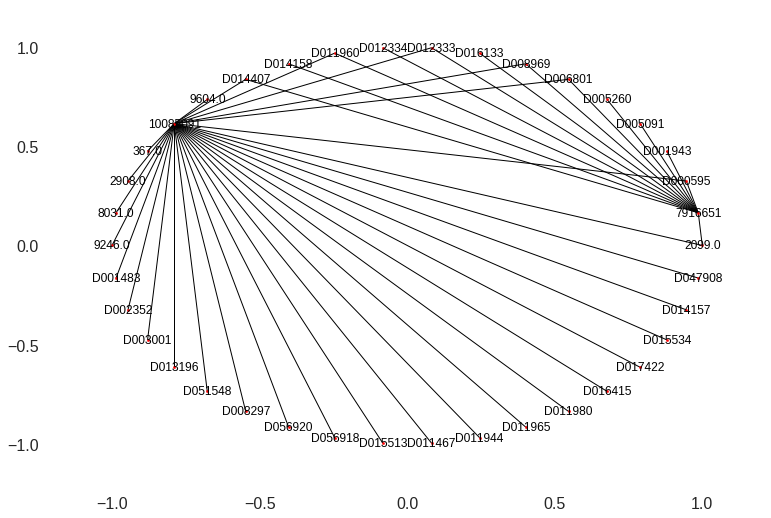

In [236]:
sns.set_context("poster")
sns.set_style("whitegrid",{"axes.grid":False,"axes.linewidth":0.0})
p2 = nx.circular_layout(g2)
# p2 = {
#     7916651:(-0.3,-0.33),
#     10085091:(-0.3,0.33),
#     2099.0:(-1.0,0.17),
#     'D014407':(0.35,0.25),
#     'D000595':(0.35,-0.25),
#     'D011960':(0.35,0.15),
#     'D006801':(0.35,-0.15),
#     'D008969':(0.35,-0.05),
#     'D012333':(0.35,0.05)
# }
gl = nx.draw_networkx_labels(g2,pos=p2)
ge = nx.draw_networkx_edges(g2,pos=p2)
gn = nx.draw_networkx_nodes(g2,pos=p2,node_size=5)
# gn.axes.xaxis.set_ticklabels([])
# gn.axes.yaxis.set_ticklabels([])